In [ ]:
import cv2
import numpy as np

print(f"OpenCV version is: {cv2.__version__}")

if True:  # change to True if you want to use the notebook locally
    # and use cv2_imshow from matplotlib (eg. Vscode)
    import matplotlib.pyplot as plt

    def cv2_imshow(img):
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

In [ ]:
GREEN = (0, 255, 0)
RED = (0, 0, 255)

def draw_quadrilateral(img, p_list, color, girth):
    shifted = np.concat([p_list[-1:],p_list[:-1]]).astype(int)
    zip_list = list(zip(p_list, shifted))

    for (p1, p2) in zip_list:
        cv2.line(img, p1, p2, color, girth)

def draw_square(img, p1, p3, color, girth):
    p_matrix = np.vstack([p1, p3])
    new = (p_matrix * np.eye(2), p_matrix * np.array([0,1,1,0]).reshape(2,2))

    p2, p4 = list(map(lambda x: x[np.nonzero(x)], new))
    p4 = p4[::-1]

    p_list = np.array([p1, p2, p3, p4]).astype(int)
    draw_quadrilateral(img, p_list, color, girth)

def drawMarkers(img, corners, ids):
    if ids is None:
        return

    square_size = 7
    for i in range(ids.shape[0]):
        c = corners[i][0]
        id = ids[i][0]
        draw_quadrilateral(img, c.astype(int), GREEN, 1)
        draw_square(img, c[0] - (square_size // 2), c[0] + (square_size // 2), RED, 1)
        cv2.putText(img, f"{id}", c[0].astype(int), cv2.FONT_HERSHEY_SIMPLEX, 1, RED, 2)

In [ ]:
def input_parse(img = None, filename = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        assert False

    return current

In [109]:
def get_objpoints(shape, width):
    x, y = shape
    xx, yy = np.meshgrid(
        np.linspace(0, width * x, x + 1), 
        np.linspace(0, width * y, y + 1), 
    )
    xx, yy = xx.reshape(-1), yy.reshape(-1)
    objarr = np.vstack([xx, yy, np.zeros(len(xx))]).T

    return objarr.astype(np.float32)

def get_marker_objp(width):
    objp = get_objpoints((1,1), width)
    objp[[2,3]] = objp[[3,2]]
    return objp

get_objpoints((3,5), 70)

array([[  0.,   0.,   0.],
       [ 70.,   0.,   0.],
       [140.,   0.,   0.],
       [210.,   0.,   0.],
       [  0.,  70.,   0.],
       [ 70.,  70.,   0.],
       [140.,  70.,   0.],
       [210.,  70.,   0.],
       [  0., 140.,   0.],
       [ 70., 140.,   0.],
       [140., 140.,   0.],
       [210., 140.,   0.],
       [  0., 210.,   0.],
       [ 70., 210.,   0.],
       [140., 210.,   0.],
       [210., 210.,   0.],
       [  0., 280.,   0.],
       [ 70., 280.,   0.],
       [140., 280.,   0.],
       [210., 280.,   0.],
       [  0., 350.,   0.],
       [ 70., 350.,   0.],
       [140., 350.,   0.],
       [210., 350.,   0.]], dtype=float32)

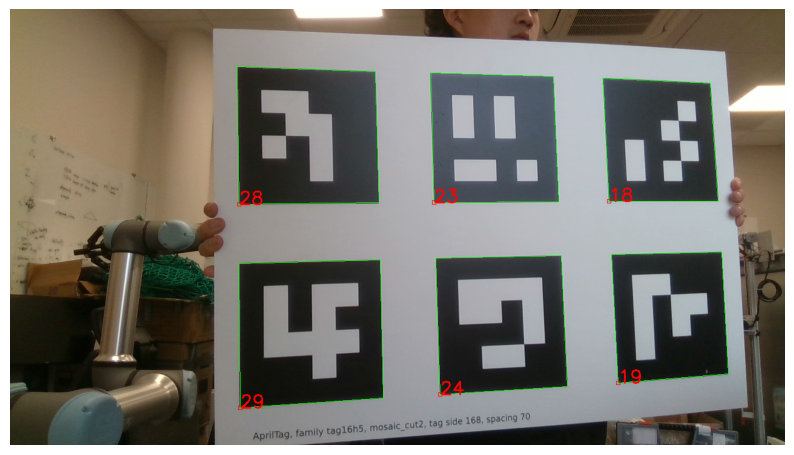

0
1
2


(array([[[ 380.,  658.]],
 
        [[ 378.,  420.]],
 
        [[ 378.,  322.]],
 
        [[ 375.,   95.]],
 
        [[ 616.,  642.]],
 
        [[ 611.,  414.]],
 
        [[ 609.,  319.]],
 
        [[ 603.,  103.]],
 
        [[ 710.,  636.]],
 
        [[ 703.,  411.]],
 
        [[ 700.,  319.]],
 
        [[ 695.,  105.]],
 
        [[ 920.,  623.]],
 
        [[ 910.,  407.]],
 
        [[ 906.,  318.]],
 
        [[ 897.,  111.]],
 
        [[1004.,  617.]],
 
        [[ 993.,  405.]],
 
        [[ 989.,  317.]],
 
        [[ 979.,  114.]],
 
        [[1186.,  602.]],
 
        [[1175.,  401.]],
 
        [[1169.,  317.]],
 
        [[1156.,  122.]]], dtype=float32),
 array([[29],
        [28],
        [24],
        [23],
        [19],
        [18]], dtype=int32))

In [ ]:
def find_aruco_info(img = None, filename = None):
    img = input_parse(img, filename)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)

    corners, ids, _ = detector.detectMarkers(img)

    img_ = img.copy()
    drawMarkers(img_, corners, ids)
    cv2_imshow(img_)
    corners = np.array(list(corners)).reshape(-1,4,1,2)

    return (corners, ids)

def permute_corners(corners):
    corners = corners.reshape(-1,1,2)
    perm = np.array([0,1,4,5,3,2,7,6])
    coords = np.arange(len(perm))

    for i in range(3):
        corners[coords + (i * len(perm))] = corners[perm + (i * len(perm))]

    return corners

find_aruco_info(filename = 'data1/img1.png')

In [104]:
def calibrate(img = None, filename = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)

    corners = find_aruco_info(img = current)[0]
    objpoints = get_marker_objp(185)

    return cv2.calibrateCamera(
        objectPoints = [objpoints] * 6,
        imagePoints = corners,
        imageSize = gray.shape[::-1],
        cameraMatrix = None,
        distCoeffs = None,
    )

calibrate(filename = 'data1/img1.png')
''

''

In [105]:
def get_undistort_rectify(img = None, filename = None, alpha = 1):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
    size = gray.shape[::-1]

    cal = calibrate(img = current)
    _, cMat, dCoeff, _, _ = cal

    newCMat, _ = cv2.getOptimalNewCameraMatrix(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        imageSize = size,
        alpha = alpha,
        newImgSize = size,
    )

    undistort, rectify = cv2.initUndistortRectifyMap(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        R = np.eye(3),
        newCameraMatrix = newCMat,
        size = size,
        m1type = cv2.CV_32FC1,
    )

    return (undistort, rectify)

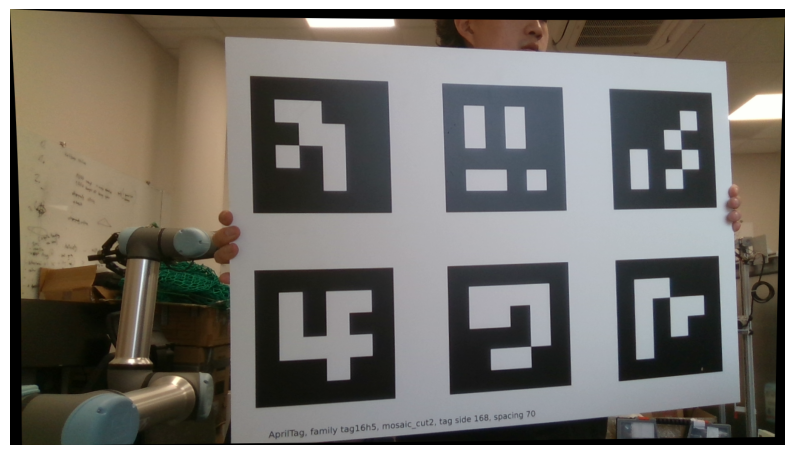

In [106]:

def undistort(img = None, filename = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    (undistort, rectify) = get_undistort_rectify(img = current)

    undistorted = cv2.remap(
        src = current,
        map1 = undistort,
        map2 = rectify,
        interpolation = cv2.INTER_LINEAR,
    )

    return undistorted

img = undistort(filename = 'data1/img1.png')
cv2_imshow(img)